In [1]:
cwd = "/Users/jonathanlin/Documents/GitHub/research_transfer/"
csv_path = cwd + "datasets/Animal_Kingdom/action_recognition/annotation/val.csv"

import pandas as pd
import PIL
import random
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration, Blip2Model
import torch
import json
from torchvision import transforms

import sys

sys.path.append(cwd)
from blip2_run import clip2_baseline

In [2]:
df = pd.read_excel("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/df_action.xlsx")
landmarks_frame = pd.read_csv(csv_path, delimiter = " ")

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
caption_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", torch_dtype=torch.float32
)
model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

custom_model = clip2_baseline.load_from_checkpoint(checkpoint_path="/Users/jonathanlin/Documents/GitHub/research_transfer/temp.ckpt")

f = open("/Users/jonathanlin/Documents/GitHub/research_transfer/data_tools/ak_ar_images/converted.json", "r")
convert = json.load(f)
f.close()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

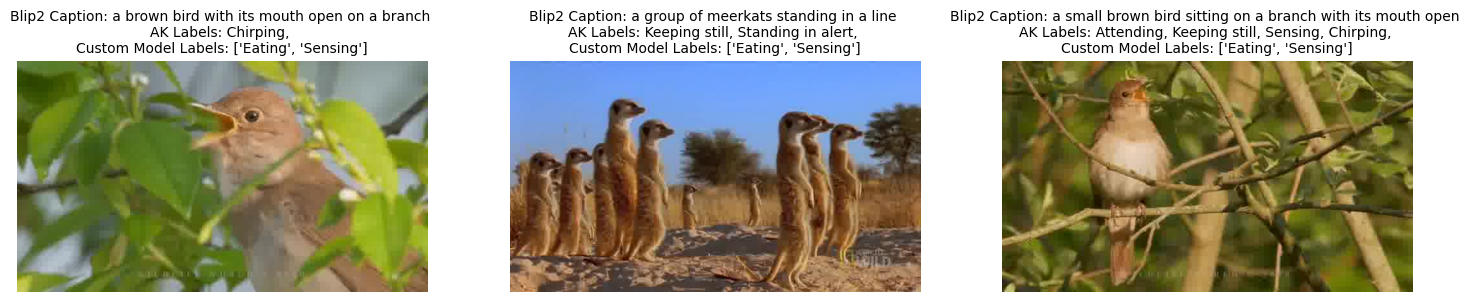

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i in range(3):
    actions = []

    sample_index = random.randint(0, landmarks_frame.shape[0])

    img_path = landmarks_frame.iloc[sample_index, 3]

    # get the action labels
    action_labels = landmarks_frame.iloc[sample_index, 4].split(",")
    for j in range(len(action_labels)):
        action_labels[j] = int(action_labels[j])

    for action in action_labels:
        actions.append(df.at[action, "action"])

    # process the action labels to be more readable
    action_text = ""
    for j, action in enumerate(actions):
        if j > 0 and j % 4 == 0:
            action_text += "\n"
        action_text += action + ", "

    # get the blip2 caption
    image = PIL.Image.open(cwd + "datasets/Animal_Kingdom/action_recognition/dataset/image/" + img_path, mode="r")
    inputs = processor(images=image, return_tensors="pt").to(torch.float32)
    generated_ids = caption_model.generate(**inputs)
    inputs = inputs["pixel_values"]

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()


    # get the labels from the custom blip2 model
    image = PIL.Image.open(cwd + "datasets/Animal_Kingdom/action_recognition/dataset/image/" + img_path, mode="r")
    image = transform(image)
    image = torch.reshape(image, (3, 224, 224))
    image = image.to(torch.float32)
    image2 = image.clone()
    # have to create 2 copies to use the model for some reason
    new = torch.stack((image, image2), dim=0)
    y_hat = custom_model(new)
    custom_model_labels = []
    for j, x in enumerate(y_hat[0]):
        if y_hat[0][j] != 0:
            custom_model_labels.append(df.at[convert[str(j)], "action"])

    # Load the image from the .jpg file
    image_path = cwd + "datasets/Animal_Kingdom/action_recognition/dataset/image/" + img_path
    image = mpimg.imread(image_path)

    # show the image
    axes[i].imshow(image)

    # Add a title to the image
    title = f"Blip2 Caption: {generated_text} \nAK Labels: {action_text}\nCustom Model Labels: {custom_model_labels}"
    axes[i].set_title(title, fontsize=10)

for ax in axes:
    ax.axis('off')
plt.show()